<a href="https://colab.research.google.com/github/Rob174/Astronomy/blob/Astronomy/Mod%C3%A8le000001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fonctions de base

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TIPE'
import os
from tensorflow.python.client import device_lib
print("Utilise le",str(device_lib.list_local_devices()[0])[15:18])
print()
print()
from google.colab import files
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.layers import Layer
import matplotlib.gridspec as gridspec
from keras.models import Sequential
from keras.layers import Dense, Dropout,concatenate,Subtract,Multiply,Average, Concatenate,Reshape, Add, BatchNormalization
from keras.layers import Reshape,Lambda
from keras.layers.core import Activation
from keras.optimizers import SGD, Adam
from keras import models
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, AveragePooling2D,MaxPooling2D
import keras.losses
from keras.layers.core import Flatten
from keras import backend as K
import numpy as np
import scipy
from PIL import Image
from keras.layers import Input
from keras.models import Model
import cv2
import matplotlib.pyplot as plt
images = ["Galaxies_resized/"+f for f in os.listdir("Galaxies_resized/")]
noises = []

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/TIPE
Utilise le CPU




Using TensorFlow backend.


In [0]:
# Install latest Tensorflow build
# !pip install -q tf-nightly-2.0-preview
# from tensorflow import summary
# %load_ext notebook

In [3]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-07-06 14:37:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.3.53.115, 52.54.84.112, 52.54.237.49, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.3.53.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17556757 (17M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.17’

ngrok-stable-linux- 100%[===================>]  16.74M  16.4MB/s    in 1.0s    

2019-07-06 14:37:46 (16.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.17’ saved [17556757/17556757]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [4]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://0df5aefb.ngrok.io


In [0]:
def next_batch(batch_size, images,tailleAttendue,formatArray):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    """
    imageEntreeTensor = []
    imageSortieTensor = []
    while len(imageEntreeTensor) < batch_size:
        try:
            np.random.shuffle(images)#choix aléatoire de l'image
            image = cv2.imread(images[0])#Ouvre en rgb l'image nettoyée
            resizedImage = cv2.resize(image,(tailleAttendue,tailleAttendue))
            imageSortieTensor.append(np.array(resizedImage,dtype=formatArray))
            imageEntreeTensor.append(np.array(resizedImage,dtype=formatArray))
        except:
            print("Error in next_batch")
    imageEntreeTensor = np.array(imageEntreeTensor,formatArray)
    return [imageEntreeTensor,imageEntreeTensor]

In [0]:
def next_batch_bruit_voile(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy + np.random.normal(bruitParam[0],bruitParam[1],imageSortieTensorCopy.shape),plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def next_batch_bruit_voile_2(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    La versison 2 fait les  modification sélectives de couleurs après avoir ajouté le bruit
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] += np.random.normal(bruitParam[0],bruitParam[1])
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy /= np.max(imageSortieTensorCopy)
    imageSortieTensorCopy *= plageVal[1]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy,plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def normalisation(arrayL,plageEntree=[0,255],plageSortie=[0,1]):
    assert plageEntree != plageSortie
    assert plageEntree[1]>0 and plageSortie[1] > 0
    formatArray = [array.dtype for array in arrayL]
    L = [np.array(array,dtype=np.float) for array in arrayL]
    for i in range(len(L)):
        L[i] = np.array((L[i]-plageEntree[0])/(plageEntree[1]-plageEntree[0])*(plageSortie[1]-plageSortie[0])+plageSortie[0],formatArray[i])
    return L

In [0]:
def LarrayFloatToUint(L):
    return [np.array(array,np.uint) for array in L]

In [0]:
def tauxApprentissage(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def differenceAcceptee(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def convertToUint(array):
    return np.array(normalisation(array,[0,1],[0,255]),dtype=np.uint8)

In [0]:
def convertToUintL(L):
    Lresult = []
    print("Entree : ",len(L))
    for i in range(len(L)):
        Lresult.append(np.array(normalisation(L[i],[0,1],[0,255]),dtype=np.uint8))
    print("Sortie : ",len(Lresult))
    return Lresult

In [0]:
index = np.arange(0,len(images))
np.random.shuffle(index)
trainingData = [images[i] for i in index[:int(0.6*len(images))]]
evalData = [images[i] for i in index[int(0.6*len(images))-1:]]

In [0]:
# source : https://stackoverflow.com/questions/46418373/how-to-resize-interpolate-a-tensor-in-keras
def interpolation(h,w,inputTensor):
    def resize_like(inputTensor,h,w):
        return tf.image.resize_nearest_neighbor(inputTensor, [h, w])

    return Lambda(resize_like, arguments={'h':h,'w':w})(inputTensor)

In [16]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
def SELU(x):
    return 1.0507*K.elu(x,alpha=1.67326)

get_custom_objects().update({'custom_activation': Activation(SELU)})

# A mettre pour le modèle : Activation(SELU)

W0706 14:38:03.920131 140330649421696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [0]:
class LRN2D(Layer):#Normalisation de réponse locale
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__(**kwargs)
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = K.shape(X)
        half_n = self.n // 2
        input_sqr = K.square(X)
        extra_channels = K.zeros((b, ch + 2 * half_n, r, c))
        input_sqr = K.concatenate([extra_channels[:, :half_n, :, :],
                                   input_sqr,
                                   extra_channels[:, half_n + ch:, :, :]],
                                  axis=1)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i + ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Discriminateur

In [0]:
def discriminateur():
    inpt = Input(shape = (199, 199, 3),name='Image')
    Lsummary = []

    
    bruit = Convolution2D(filters=1,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME')(inpt)
    Lsummary.append(['Couche0']+[tf.summary.image(name='Couche%i_filtre%i'%(0,i),tensor=bruit[:,:,:,i]) for i in range(bruit.get_shape()[-1])])
    bruit = BatchNormalization()(bruit)
    Lsummary.append(['Couche1']+[tf.summary.image(name='Couche%i_filtre%i'%(1,i),tensor=bruit[:,:,:,i]) for i in range(bruit.get_shape()[-1])])
    bruit = Activation(SELU)(bruit)
    Lsummary.append(['Couche2']+[tf.summary.image(name='Couche%i_filtre%i'%(2,i),tensor=bruit[:,:,:,i]) for i in range(bruit.get_shape()[-1])])
    bruit = Convolution2D(filters=3,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME')(bruit)
    Lsummary.append(['Couche3']+[tf.summary.image(name='Couche%i_filtre%i'%(3,i),tensor=bruit[:,:,:,i]) for i in range(bruit.get_shape()[-1])])
    bruit = BatchNormalization()(bruit)
    Lsummary.append(['Couche4']+[tf.summary.image(name='Couche%i_filtre%i'%(4,i),tensor=bruit[:,:,:,i]) for i in range(bruit.get_shape()[-1])])
    bruit = Activation(SELU)(bruit)
    Lsummary.append(['Couche5']+[tf.summary.image(name='Couche%i_filtre%i'%(5,i),tensor=bruit[:,:,:,i]) for i in range(bruit.get_shape()[-1])])
    bruit = Subtract()([inpt,bruit])
    Lsummary.append(['Couche6']+[tf.summary.image(name='Couche%i_filtre%i'%(6,i),tensor=bruit[:,:,:,i]) for i in range(bruit.get_shape()[-1])])
    bruit = MaxPooling2D(pool_size=3,padding='VALID')(bruit)
    Lsummary.append(['Couche7']+[tf.summary.image(name='Couche%i_filtre%i'%(7,i),tensor=bruit[:,:,:,i]) for i in range(bruit.get_shape()[-1])])

    bruit1 = Convolution2D(filters=1,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME')(bruit)
    Lsummary.append(['Couche8']+[tf.summary.image(name='Couche%i_filtre%i'%(8,i),tensor=bruit1[:,:,:,i]) for i in range(bruit1.get_shape()[-1])])
    bruit1 = BatchNormalization()(bruit)
    Lsummary.append(['Couche9']+[tf.summary.image(name='Couche%i_filtre%i'%(9,i),tensor=bruit1[:,:,:,i]) for i in range(bruit1.get_shape()[-1])])
    bruit1 = Activation(SELU)(bruit)
    Lsummary.append(['Couche10']+[tf.summary.image(name='Couche%i_filtre%i'%(10,i),tensor=bruit1[:,:,:,i]) for i in range(bruit1.get_shape()[-1])])
    bruit1 = Convolution2D(filters=3,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME')(bruit)
    Lsummary.append(['Couche11']+[tf.summary.image(name='Couche%i_filtre%i'%(11,i),tensor=bruit1[:,:,:,i]) for i in range(bruit1.get_shape()[-1])])
    bruit1 = BatchNormalization()(bruit)
    Lsummary.append(['Couche12']+[tf.summary.image(name='Couche%i_filtre%i'%(12,i),tensor=bruit1[:,:,:,i]) for i in range(bruit.get_shape()[-1])])
    bruit1 = Activation(SELU)(bruit)
    Lsummary.append(['Couche13']+[tf.summary.image(name='Couche%i_filtre%i'%(13,i),tensor=bruit1[:,:,:,i]) for i in range(bruit1.get_shape()[-1])])
    bruit1 = Subtract()([bruit,bruit1])
    Lsummary.append(['Couche14']+[tf.summary.image(name='Couche%i_filtre%i'%(14,i),tensor=bruit1[:,:,:,i]) for i in range(bruit1.get_shape()[-1])])
    bruit = MaxPooling2D(pool_size=3,padding='VALID')(bruit1)
    Lsummary.append(['Couche15']+[tf.summary.image(name='Couche%i_filtre%i'%(15,i),tensor=bruit[:,:,:,i]) for i in range(bruit.get_shape()[-1])])
    
    
    def inception(prevShapes,comptCouche):
        LsummaryInception = []
        inpt = Input(shape = prevShapes)
        coucheT0 = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME')(inpt)
        LsummaryInception.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=coucheT0[:,:,:,i]) for i in range(coucheT0.get_shape()[-1])])
        comptCouche += 1

        coucheT1 = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME')(inpt)
        LsummaryInception.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=coucheT1[:,:,:,i]) for i in range(coucheT1.get_shape()[-1])])
        comptCouche += 1
        coucheT1 = Convolution2D(filters=100,kernel_size=(1,3),activation=None,strides=(1,1),padding='SAME')(coucheT1)
        LsummaryInception.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=coucheT1[:,:,:,i]) for i in range(coucheT1.get_shape()[-1])])
        comptCouche += 1
        coucheT1 = Convolution2D(filters=100,kernel_size=(3,1),activation=None,strides=(1,1),padding='SAME')(coucheT1)
        LsummaryInception.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=coucheT1[:,:,:,i]) for i in range(coucheT1.get_shape()[-1])])
        comptCouche += 1

        couche = Concatenate(axis=-1)([coucheT0,coucheT1])
        LsummaryInception.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=couche[:,:,:,i]) for i in range(couche.get_shape()[-1])])
        comptCouche += 1
        couche = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME')(couche)
        LsummaryInception.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=couche[:,:,:,i]) for i in range(couche.get_shape()[-1])])
        comptCouche += 1
        couche = Add()([couche,inpt])
        LsummaryInception.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=couche[:,:,:,i]) for i in range(couche.get_shape()[-1])])
        comptCouche += 1
        
        return Model(inputs=[inpt],outputs=[couche]),LsummaryInception,comptCouche
    
    comptCouche = 16
    coucheAdaptation = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME')(inpt)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=coucheAdaptation[:,:,:,i]) for i in range(coucheAdaptation.get_shape()[-1])])
    comptCouche += 1
    inceptionModel,LsummaryInception,comptCouche = inception(coucheAdaptation.get_shape().as_list()[1:],comptCouche=comptCouche)
    image = inceptionModel(coucheAdaptation)
    Lsummary += LsummaryInception
    image = LRN2D(n=21,k=2,alpha=10**-4,beta=0.75)(image)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=image[:,:,:,i]) for i in range(image.get_shape()[-1])])
    comptCouche += 1
    image = BatchNormalization()(image)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=image[:,:,:,i]) for i in range(image.get_shape()[-1])])
    comptCouche += 1
    image = Activation(SELU)(image)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=image[:,:,:,i]) for i in range(image.get_shape()[-1])])
    comptCouche += 1
    image = MaxPooling2D(pool_size=3,padding='VALID')(image)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=image[:,:,:,i]) for i in range(image.get_shape()[-1])])
    comptCouche += 1
    inceptionModel,LsummaryInception,comptCouche = inception(image.get_shape().as_list()[1:],comptCouche=comptCouche)
    image = inceptionModel(image)
    Lsummary += LsummaryInception
    image = LRN2D(n=21,k=2,alpha=10**-4,beta=0.75)(image)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=image[:,:,:,i]) for i in range(image.get_shape()[-1])])
    comptCouche += 1
    image = BatchNormalization()(image)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=image[:,:,:,i]) for i in range(image.get_shape()[-1])])
    comptCouche += 1
    image = Activation(SELU)(image)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=image[:,:,:,i]) for i in range(image.get_shape()[-1])])
    comptCouche += 1
    image = MaxPooling2D(pool_size=3,padding='VALID')(image)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=image[:,:,:,i]) for i in range(image.get_shape()[-1])])
    comptCouche += 1
    inceptionModel,LsummaryInception,comptCouche = inception(image.get_shape().as_list()[1:],comptCouche=comptCouche)
    image = inceptionModel(image)
    Lsummary += LsummaryInception
    image = LRN2D(n=21,k=2,alpha=10**-4,beta=0.75)(image)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=image[:,:,:,i]) for i in range(image.get_shape()[-1])])
    comptCouche += 1
    image = BatchNormalization()(image)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=image[:,:,:,i]) for i in range(image.get_shape()[-1])])
    comptCouche += 1
    image = Activation(SELU)(image)
    Lsummary.append(['Couche'+str(comptCouche)]+[tf.summary.image(name='Couche%i_filtre%i'%(comptCouche,i),tensor=image[:,:,:,i]) for i in range(image.get_shape()[-1])])
    comptCouche += 1
    
    resultatAnalyse = Concatenate(axis=-1)([bruit,image])
    resultatAnalyse = Flatten()(resultatAnalyse)
    resultatAnalyse = Dense(100)(resultatAnalyse)
    probabilite = Dense(1)(resultatAnalyse)
    probabilite = Activation('sigmoid')(probabilite)
    Lsummary.append(['CoucheOrig']+[tf.summary.image(name="Originale\n"+str(probabilite),tensor=inpt[:,:,:,i]) for i in range(inpt.get_shape()[-1])])
    
        
    return Model(input=inpt,output=probabilite),Lsummary

In [38]:
def train(images,eval_data,pathTmpSave,indexModele):
    pathTmpSave = pathTmpSave + 'Modele'+str(indexModele)+'_Disc.h5'
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    disc,Lsummary = discriminateur()
    print(disc.summary())
    Lloss = []
    Lresult = []
    disc.compile(loss='logcosh', optimizer=d_optim)
    from keras.utils import plot_model
    plot_model(disc, to_file='Modele'+str(indexModele)+'_Disc',show_shapes=True,show_layer_names=True)
    
    summary_writer = tf.summary.FileWriter(logdir='./logs/Modele'+str(indexModele)+'_Disc',graph=tf.get_default_graph())
    
    nbEpoch = 200
    i = 0
    rep = 2
    while i < nbEpoch:
        disc.save_weights(pathTmpSave)
        image2,imageBruitee2 = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
        
        current_learning_rate = tauxApprentissage(i,10**-4,10,10**-5)
        K.set_value(disc.optimizer.lr, current_learning_rate)
        
        entree = np.concatenate((image2, imageBruitee2))
        sortie = np.array(7* [1] + 7*[0])
        loss = disc.train_on_batch(entree,sortie)
        Lloss.append(loss)
        if np.isnan(loss) == True and i < 10:
            disc = discriminateur()
            disc.compile(loss='logcosh', optimizer=d_optim)
            i = 0
            print("Reset")
        elif np.isnan(loss) == True and rep > 0:
            disc.load_weights(pathTmpSave)
            nbEpoch += 1
            rep -= 1
            Lresult = []
        elif np.isnan(loss) == True and rep == 0:
            break
            
        else:
            rep = 10
        print("Epoch %i, loss %f"%(i,loss))
        summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Erreur : Logcosh", 
                                             simple_value=loss) ])
        summary_writer.add_summary(summary_loss,i)
        if i % 50 == 0:
            for summary in Lsummary:
                for summary_elem in summary[1:]:
                    print(summary_elem[0])
                    summary_val = tf.Summary(value=[tf.Summary.Value(tag=summary_elem[0], 
                                                         image=summary_elem[1]) ])
                    summary_writer.add_summary(summary_val,i)
            summary_writer.close()
            summary_writer.reopen()
        Lloss.append(loss)
        i += 1
    
    return Lloss
Lloss = train(trainingData, evalData,'./Restore/',1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("ac...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image (InputLayer)              (None, 199, 199, 3)  0                                            
__________________________________________________________________________________________________
conv2d_201 (Conv2D)             (None, 199, 199, 100 400         Image[0][0]                      
__________________________________________________________________________________________________
model_37 (Model)                (None, 199, 199, 100 100500      conv2d_201[0][0]                 
__________________________________________________________________________________________________
lr_n2d_28 (LRN2D)               (None, 199, 199, 100 0           model_37[1][0]                   
__________________________________________________________________________________________________
batch_norm

ValueError: ignored

Text(0, 0.5, 'Logcosh')

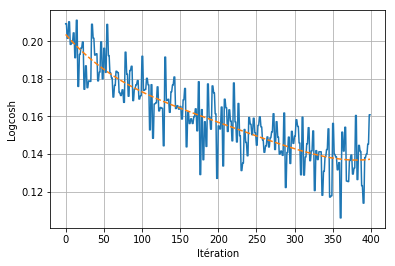

In [0]:
x = list(range(len(Lloss)))
plt.plot(x,Lloss)
coeff = np.polyfit(x,Lloss,4)
reg = [elem**4*coeff[0]+elem**3*coeff[1]+elem**2*coeff[2]+elem**1*coeff[3]+coeff[4] for elem in x]
plt.plot(x,reg,linestyle='--')
plt.grid()
plt.xlabel('Itération')
plt.ylabel('Logcosh')

In [0]:
def generateur():
    inpt = Input(shape = (199, 199, 3),name='ImageATraiter')
    couche = Dense(500,name='generateurDense0',activation='relu')(inpt)
    couche = Dense(50,name='generateurDense1',activation='relu')(couche)
    couche = Dense(3,name='generateurSortie')(couche)
    couche = Add(name='add')([inpt,couche])
    model = Model(input=inpt,output=couche)
    return model

In [0]:
def preTrainGenerateur():
    gen = generateur()
    optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    gen.compile(loss='mean_absolute_error', optimizer=optim)
    print(gen.summary())
    from keras.utils import plot_model
    plot_model(gen, to_file='modelGen.png',show_shapes=True,show_layer_names=True)
    i = 0
    Lanalyse = []
    Lloss = []
    nbEpoch = 1000
    while i < nbEpoch:
        gen.save_weights("_tmp_preTrainGen.h5")
        image,imageBruitee = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
        current_learning_rate = tauxApprentissage(i,10**-4,10,10**-7)
        K.set_value(gen.optimizer.lr, current_learning_rate)
        if i % 10 == 0:
            predictedImage = convertToUint(gen.predict(image))
            predictedImageBruitee = convertToUint(gen.predict(imageBruitee))
            Lanalyse.append([image,predictedImage,imageBruitee,predictedImageBruitee])
        x = np.concatenate((image,imageBruitee))
        y = np.concatenate((image,image))
        loss = gen.train_on_batch(x,y)
        diff = differenceAcceptee(i,1,10,0.006)
        print("Loss %i accepte < %f : "%(i,diff),loss)
        Lloss.append(loss)
        if loss > diff:
            gen.load_weights("_tmp_preTrainGen.h5")
            i -= 1
        i += 1
    return Lloss,Lanalyse
Lloss,Lanalyse = preTrainGenerateur()

W0627 23:20:00.962149 139720111245184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 23:20:00.978866 139720111245184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("ad...)`
  import sys
W0627 23:20:01.062339 139720111245184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 23:20:01.080308 139720111245184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageATraiter (InputLayer)      (None, 199, 199, 3)  0                                            
__________________________________________________________________________________________________
generateurDense0 (Dense)        (None, 199, 199, 500 2000        ImageATraiter[0][0]              
__________________________________________________________________________________________________
generateurDense1 (Dense)        (None, 199, 199, 50) 25050       generateurDense0[0][0]           
__________________________________________________________________________________________________
generateurSortie (Dense)        (None, 199, 199, 3)  153         generateurDense1[0][0]           
__________________________________________________________________________________________________
add (Add) 

W0627 23:20:01.861403 139720111245184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0627 23:20:01.863348 139720111245184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Loss 0 accepte < 1.000000 :  0.091261335
Loss 1 accepte < 0.794328 :  0.06679954
Loss 2 accepte < 0.630957 :  0.088709295
Loss 3 accepte < 0.501187 :  0.06751726
Loss 4 accepte < 0.398107 :  0.055448174
Loss 5 accepte < 0.316228 :  0.059920903
Loss 6 accepte < 0.251189 :  0.06645689
Loss 7 accepte < 0.199526 :  0.066528074
Loss 8 accepte < 0.158489 :  0.07664976
Loss 9 accepte < 0.125893 :  0.076868944
Loss 10 accepte < 0.100000 :  0.06033073
Loss 11 accepte < 0.079433 :  0.054678243
Loss 12 accepte < 0.063096 :  0.06560705
Loss 12 accepte < 0.063096 :  0.05803818
Loss 13 accepte < 0.050119 :  0.057330366
Loss 13 accepte < 0.050119 :  0.073458396
Loss 13 accepte < 0.050119 :  0.069370665
Loss 13 accepte < 0.050119 :  0.09753728
Loss 13 accepte < 0.050119 :  0.06393238
Loss 13 accepte < 0.050119 :  0.06561266
Loss 13 accepte < 0.050119 :  0.0676084
Loss 13 accepte < 0.050119 :  0.059605304
Loss 13 accepte < 0.050119 :  0.06734271
Loss 13 accepte < 0.050119 :  0.072468266
Loss 13 accepte

KeyboardInterrupt: ignored

In [0]:
plt.figure(figsize=(20,500))
for i,imgGpe in enumerate(Lanalyse):
    for iImg,img in enumerate(imgGpe):
        plt.subplot(len(Lanalyse),4,1+4*i+iImg)
        plt.imshow(img[0,:,:,:])

In [0]:
x = list(range(len(Lloss)))
yMoy = []
nb = 50
for i in range(len(Lloss)):
    if i+nb >= len(Lloss):
        yMoy.append(np.mean(Lloss[i:]))
    else:
        yMoy.append(np.mean(Lloss[i:i+nb]))
plt.plot(x,yMoy)

coeff = np.polyfit(x,yMoy,4)
reg = [elem**4*coeff[0]+elem**3*coeff[1]+elem**2*coeff[2]+elem**1*coeff[3]+coeff[4] for elem in x]
plt.plot(x,reg,linestyle='--')
plt.grid()

In [0]:
def differenceAcceptee(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if epoch < lim else (ampl*10**-((lim)/tau)-0.1)/(lim-200)*(epoch-lim)+ampl*10**-((lim)/tau)

In [0]:
def erreurAcceptable(erreur,it,amplH,tauH,limH,amplB,tauB,limB):
    def f(epoch,ampl,tau):
        return ampl*10**-((epoch)/tau)
    toleranceH = f(it,amplH,tauH) if it < limH else (f(it,amplH,tauH)-0.1)/(limH-200)+f(limH,amplH,tauH)
    toleranceB = f(it,amplB,tauB) if it < limB else (f(it,amplB,tauB)-0.1)/(limB-200)+f(limB,amplB,tauB)
    print("Itération %i Erreur de %f est entre %f et %f ? "%(it,erreur,toleranceH,toleranceB))
    if toleranceH < toleranceB:
        raise ValueError
    if toleranceB <= erreur <= toleranceH:
        print(True)
        return True
    else:
        print(False)
        return False

In [0]:
def trainGenDisc():
    Lloss,loss = [],np.nan
    idTest = 0
    while np.isnan(loss) == True or loss > 1:
        idTest += 1
        tensorboard = keras.callbacks.TensorBoard(
            log_dir='/tmp/my_tf_logs',
            histogram_freq=0,
            batch_size=7,
            write_graph=True,
            write_grads=True
        )
        gen = generateur()
        gen.load_weights("_tmp_preTrainGen.h5")

        inpt = Input(shape = (199, 199, 3),name='ImageTraitee')
        analyseResultat = Reshape((3,1,1))(Lambda(lambda x: K.mean(x,axis=[1,2]))(inpt))
        modelAnalyse = Model(inputs=inpt,outputs=analyseResultat)

        d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
        discCoeur,modelVisu,names = discriminateur()
        discCoeur.load_weights("_tmp_testBruitCouleurs.h5")
        inpt = Input(shape = (199, 199, 3),name='ImageEntree')
        coucheAnalyse = modelAnalyse(inpt)
        couche = discCoeur([inpt,coucheAnalyse])
        disc = Model(inputs=inpt,outputs=couche)
        disc.compile(loss='logcosh', optimizer=d_optim)

        inpt = Input(shape = (199, 199, 3),name='ImageEntree')
        couche = gen(inpt)
        coucheAnalyse = modelAnalyse(couche)
        couche = discCoeur([couche,coucheAnalyse])
        model = Model(inputs=inpt,outputs=couche)
        optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
        model.compile(loss='logcosh', optimizer=optim)
        print(model.summary())

        summary_writer = tf.summary.FileWriter('logDir/essais'+str(idTest),tf.get_default_graph())
        
        amplHGen,tauHGen,limHGen = 0.3,40*4*2,100*2*2
        amplBGen,tauBGen,limBGen = 0.05,30*4*2,100*2*2

        amplHDisc,tauHDisc,limHDisc = 0.35,220*2,100*2*2
        amplBDisc,tauBDisc,limBDisc = 0.1,30*2*4*2,100*2*2


        tensorboard.set_model(model)

        # Transform train_on_batch return value
        # to dict expected by on_batch_end callback
        def named_logs(model, logs):
          result = {}
          for l in zip(model.metrics_names, logs):
            result[l[0]] = l[1]
          return result

        from keras.utils import plot_model
        plot_model(model, to_file='model.png',show_shapes=True,show_layer_names=True)
        i = 0
        Lanalyse = []
        nbEpoch = 200
        id = 0
        while i < nbEpoch:
            image,imageBruitee = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
            current_learning_rate = tauxApprentissage(i,10**-2,10,10**-7)

            gen.save_weights("_tmp_TrainGen.h5")
            disc.save_weights("_tmp_TrainDisc.h5")
            if i % 9 == 0:
                predictedImage = convertToUint(gen.predict(image))
                predictedImageBruitee = convertToUint(gen.predict(imageBruitee))
                Lanalyse.append([image,predictedImage,imageBruitee,predictedImageBruitee])
            x = np.concatenate((image,imageBruitee))
            if i % 2 == 0:
                K.set_value(model.optimizer.lr, current_learning_rate)
                y = np.reshape([1]*14,(14,1))
                disc.trainable,gen.trainable = False,True
                loss = model.train_on_batch(x,y)
                print("gen")
                if erreurAcceptable(loss,i,amplHGen,tauHGen,limHGen,amplBGen,tauBGen,limBGen) == False:
                    gen.load_weights("_tmp_TrainGen.h5")
                    i -= 1
                else:
                    summary = tf.Summary(value=[tf.Summary.Value(tag="loss", 
                                                     simple_value=loss)])
                    summary_writer.add_summary(summary,i)
                    
            else:
                K.set_value(disc.optimizer.lr, current_learning_rate)
                y = np.reshape([1]*7+[0]*7,(14,1))
                gen.trainable,disc.trainable = False,True
                loss = disc.train_on_batch(x,y)
                print("disc")
                if erreurAcceptable(loss,i,amplHDisc,tauHDisc,limHDisc,amplBDisc,tauBDisc,limBDisc) == False:
                    disc.load_weights("_tmp_TrainDisc.h5")
                    i -= 1
                else:
                    summary = tf.Summary(value=[tf.Summary.Value(tag="loss", 
                                                     simple_value=loss)])
                    summary_writer.add_summary(summary,i)
            if np.isnan(loss) == True or loss > 1:
                break
            Lloss.append(loss)
            
            tensorboard.on_epoch_end(id, named_logs(model, Lloss))
            id += 1
            i += 1
        tensorboard.on_train_end(None)
    return Lloss
Lloss = trainGenDisc()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("ge...)`
  


[]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageEntree (InputLayer)        (None, 199, 199, 3)  0                                            
__________________________________________________________________________________________________
model_67 (Model)                (None, 199, 199, 3)  2903        ImageEntree[0][0]                
__________________________________________________________________________________________________
model_68 (Model)                (None, 3, 1, 1)      0           model_67[1][0]                   
__________________________________________________________________________________________________
model_69 (Model)                (None, 1)            968232      model_67[1][0]                   
                                                                 model_68[2][0]                   
Total p

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("ge...)`
  



[]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageEntree (InputLayer)        (None, 199, 199, 3)  0                                            
__________________________________________________________________________________________________
model_73 (Model)                (None, 199, 199, 3)  2903        ImageEntree[0][0]                
__________________________________________________________________________________________________
model_74 (Model)                (None, 3, 1, 1)      0           model_73[1][0]                   
__________________________________________________________________________________________________
model_75 (Model)                (None, 1)            968232      model_73[1][0]                   
                                                                 model_74[2][0]                   
Total 

KeyboardInterrupt: ignored

In [0]:
x = list(range(len(Lloss)))
yMoy = []
nb = 3
for i in range(len(Lloss)):
    if i+nb >= len(Lloss):
        yMoy.append(np.mean(Lloss[i:]))
    else:
        yMoy.append(np.mean(Lloss[i:i+nb]))
plt.plot(x,yMoy)

coeff = np.polyfit(x,yMoy,4)
reg = [elem**4*coeff[0]+elem**3*coeff[1]+elem**2*coeff[2]+elem**1*coeff[3]+coeff[4] for elem in x]
plt.plot(x,reg,linestyle='--')
plt.grid()

# Essai de la fonction Model

In [0]:
def discriminateur():
    inpt = Input(shape = (199, 199, 3),name='Input')
    coucheConv = Convolution2D(3,(2,2),activation='relu')(inpt)
    couche = Flatten()(coucheConv)
    couche = Dense(1)(couche)
    model = Model(inputs=inpt, outputs=couche)
    modelVisu = Model(inputs=inpt, outputs=coucheConv)
    return model,modelVisu

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 199, 199, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 198, 198, 3)       39        
_________________________________________________________________
flatten_5 (Flatten)          (None, 117612)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 117613    
Total params: 117,652
Trainable params: 117,652
Non-trainable params: 0
_________________________________________________________________
None
Epoch 0, loss 0.519768
Epoch 1, loss 0.534919
Epoch 2, loss 0.498878
Epoch 3, loss 0.520071
Epoch 4, loss 0.512690
Epoch 5, loss 0.505182
Epoch 6, loss 0.509437
Epoch 7, loss 0.495167
Epoch 8, loss 0.499577
Epoch 9, loss 0.511728


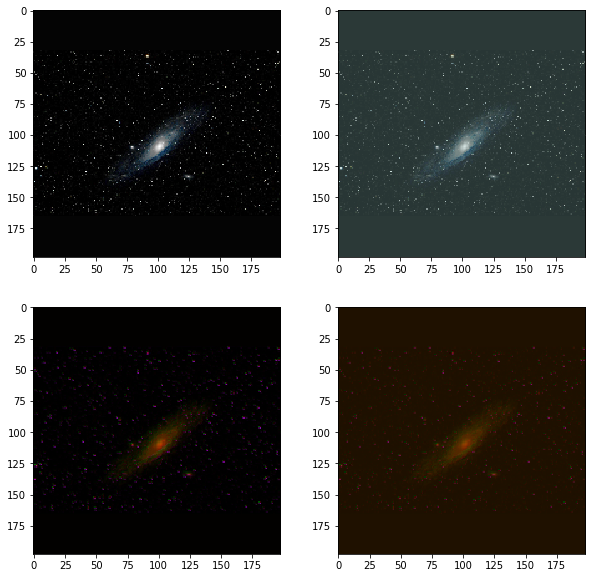

In [0]:
def train(images,eval_data):
    
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    disc,modelVisu = discriminateur()
    print(disc.summary())
    Lloss = []
    Lresult = []
    def lossF(y_true,y_pred):
        return K.abs(y_true-y_pred)
    disc.compile(loss=lossF, optimizer=d_optim)
    nbEpoch = 10
    i = 0
    rep = 2
    while i < nbEpoch:
        disc.save_weights("_tmp_testFonctionModel.h5")
        image2,imageBruitee2 = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
        current_learning_rate = tauxApprentissage(i,10**-4,10,10**-5)
        K.set_value(disc.optimizer.lr, current_learning_rate)
        X = np.concatenate((image2, imageBruitee2))
        y = np.array(7* [1] + 7*[0])
        loss = disc.train_on_batch(X,y)
        if np.isnan(loss) == True and i < 10:
            disc,modelVisu = discriminateur()
            disc.compile(loss=lossF, optimizer=d_optim)
            i = 0
            print("Reset")
        elif np.isnan(loss) == True and rep > 0:
            disc.load_weights("_tmp_testFonctionModel.h5")
            nbEpoch += 1
            rep -= 1
            Lresult = []
        elif np.isnan(loss) == True and rep == 0:
            break
            
        else:
            rep = 10
        print("Epoch %i, loss %f"%(i,loss))
        Lloss.append(loss)
        i += 1
    image,imageBruitee = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
    imageSortie = modelVisu.predict(image)
    imageBruiteeSortie = modelVisu.predict(imageBruitee)
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.imshow(convertToUint(image[0,:,:,:]))
    plt.subplot(2,2,2)
    plt.imshow(convertToUint(imageBruitee[0,:,:,:]))
    plt.subplot(2,2,3)
    plt.imshow(convertToUint(imageSortie[0,:,:,:]))
    plt.subplot(2,2,4)
    plt.imshow(convertToUint(imageBruiteeSortie[0,:,:,:]))
    
    return None
train(trainingData, evalData)